In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Trích xuất đặc trưng
# !pip install statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import pearsonr
# Chuẩn bị dữ liệu
from sklearn.preprocessing import LabelEncoder
# Xây dựng mô hình
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR


import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [ ]:
class Path():
    def __init__(self):
        self.data = '/content/drive/MyDrive/Colab Notebooks/DataVisualization/Final Project/Data/cleaned_dataset.csv'
        self.save_model = '/content/drive/MyDrive/Colab Notebooks/DataVisualization/Final Project/Model/'
path = Path()
if not os.path.exists(path.save_model):
    os.mkdir(path.save_model)
    # Tạo thêm các thư muc con
    os.mkdir(path.save_model + 'Salary_Model/')
    os.mkdir(path.save_model + 'Views_Model/')
    os.mkdir(path.save_model + 'Label_Encoders/')

In [ ]:
# Đọc dữ liệu từ file csv
df = pd.read_csv(path.data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13704 entries, 0 to 13703
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ngày cập nhật          13704 non-null  object 
 1   Lượt xem               13704 non-null  float64
 2   Khu vực tuyển          13704 non-null  object 
 3   Yêu cầu giới tính      13704 non-null  object 
 4   Cấp bậc                13704 non-null  object 
 5   Số lượng tuyển         13704 non-null  float64
 6   Hình thức làm việc     13704 non-null  object 
 7   Yêu cầu bằng cấp       13704 non-null  object 
 8   Yêu cầu kinh nghiệm    13704 non-null  object 
 9   Từ khóa                13704 non-null  object 
 10  Loại công ty           13704 non-null  object 
 11  Lương trung bình       13704 non-null  float64
 12  Nhóm tuổi              13704 non-null  object 
 13  Công việc chính        13704 non-null  object 
 14  Công việc liên quan 1  13704 non-null  object 
 15  Cô

# 1. Feature Engineering


In [ ]:
# Duỗi cột Khu vực tuyển theo dấu phẩy
df['Khu vực tuyển'] = df['Khu vực tuyển'].apply(lambda x: x.split(','))
df = df.explode('Khu vực tuyển')


# Xóa cột ngày cập nhật
df.drop(columns=['Ngày cập nhật', 'Số lượng tuyển', 'Từ khóa'], inplace=True)

column_name_dict = {
    "Lượt xem": "Views",
    "Khu vực tuyển": "Recruitment_Area",
    "Yêu cầu giới tính": "Gender_Requirement",
    "Cấp bậc": "Level",
    "Hình thức làm việc": "Working_Form",
    "Yêu cầu bằng cấp": "Degree_Requirement",
    "Yêu cầu kinh nghiệm": "Experience_Requirement",
    "Loại công ty": "Company_Type",
    "Lương trung bình": "Average_Salary",
    "Nhóm tuổi": "Age_Group",
    "Công việc chính": "Main_Job",
    "Công việc liên quan 1": "Related_Job1",
    "Công việc liên quan 2": "Related_Job2"
}

df.rename(columns=column_name_dict, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16719 entries, 0 to 13703
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Views                   16719 non-null  float64
 1   Recruitment_Area        16719 non-null  object 
 2   Gender_Requirement      16719 non-null  object 
 3   Level                   16719 non-null  object 
 4   Working_Form            16719 non-null  object 
 5   Degree_Requirement      16719 non-null  object 
 6   Experience_Requirement  16719 non-null  object 
 7   Company_Type            16719 non-null  object 
 8   Average_Salary          16719 non-null  float64
 9   Age_Group               16719 non-null  object 
 10  Main_Job                16719 non-null  object 
 11  Related_Job1            16719 non-null  object 
 12  Related_Job2            16719 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.8+ MB


- Dữ liệu gồm các cột phân loại, các cột này chính là các các cột đặc trưng của dữ liệu và không có dữ liệu thiếu. Cột mục tiêu của chúng ta dự đoán được  Mức lương trung bình có thể deal với doanh nghiệp hoặc doanh nghiệp đề suất cho các ứng viên và có bao nhiêu người đang quan tâm công việc này.
- Tiếp theo chúng ta sẽ xem có mức lương nào bị outlier không. Việc loại bở outlier giúp cho mô hình có thể bị hoạt động hiệu quả hơn

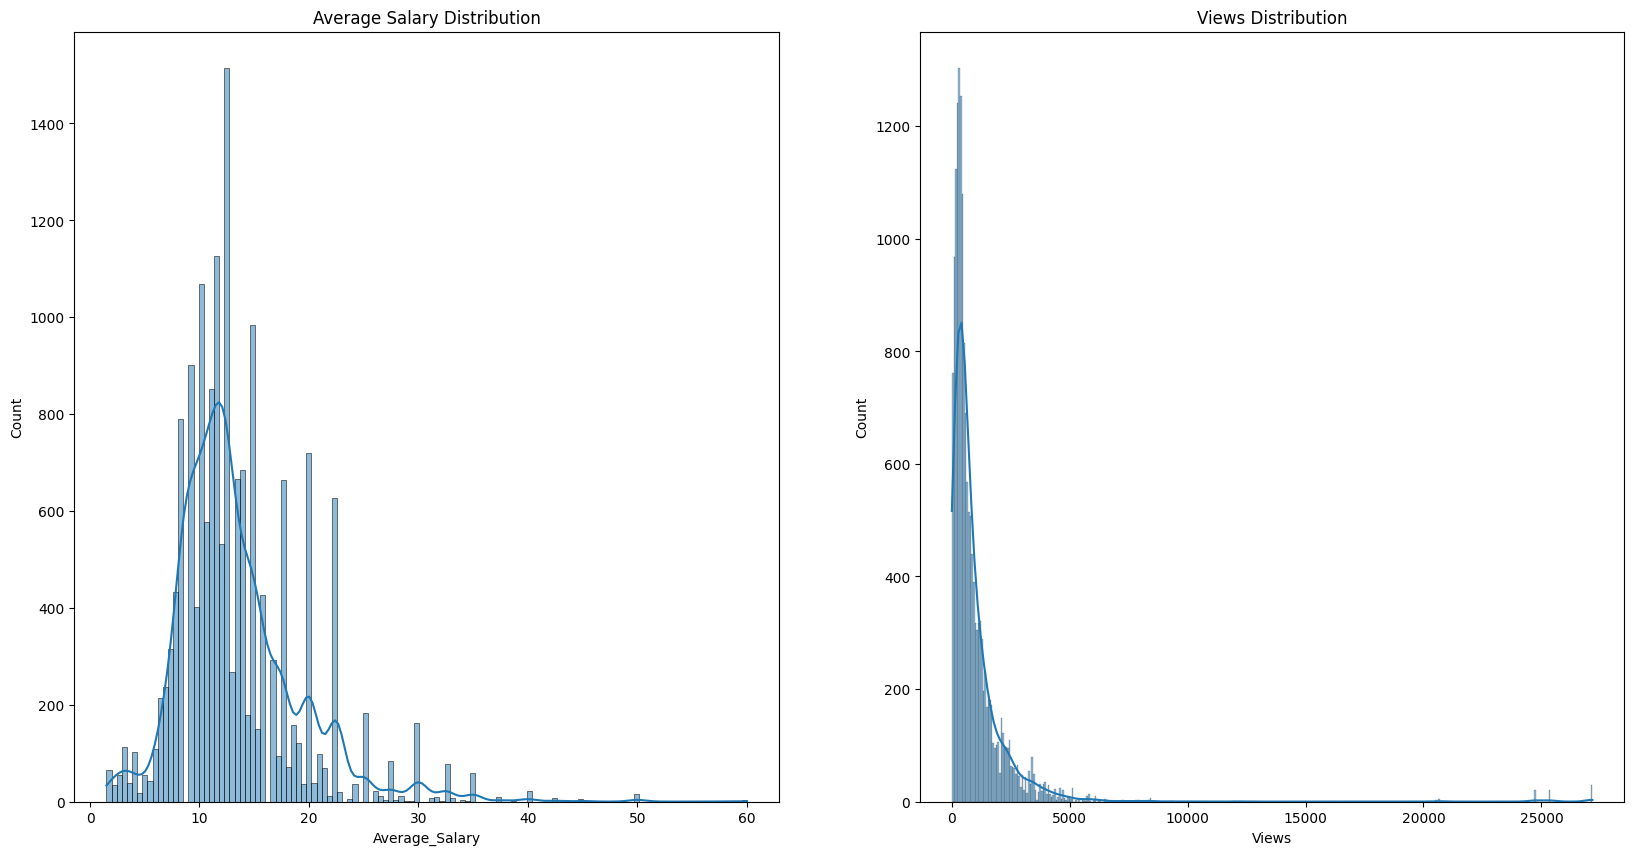

In [ ]:
# Biểu đò distribution của lương trung bình và lượt xem
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Average_Salary'], kde=True)
plt.title('Average Salary Distribution')
plt.subplot(1, 2, 2)
sns.histplot(df['Views'], kde=True)
plt.title('Views Distribution')
plt.show()

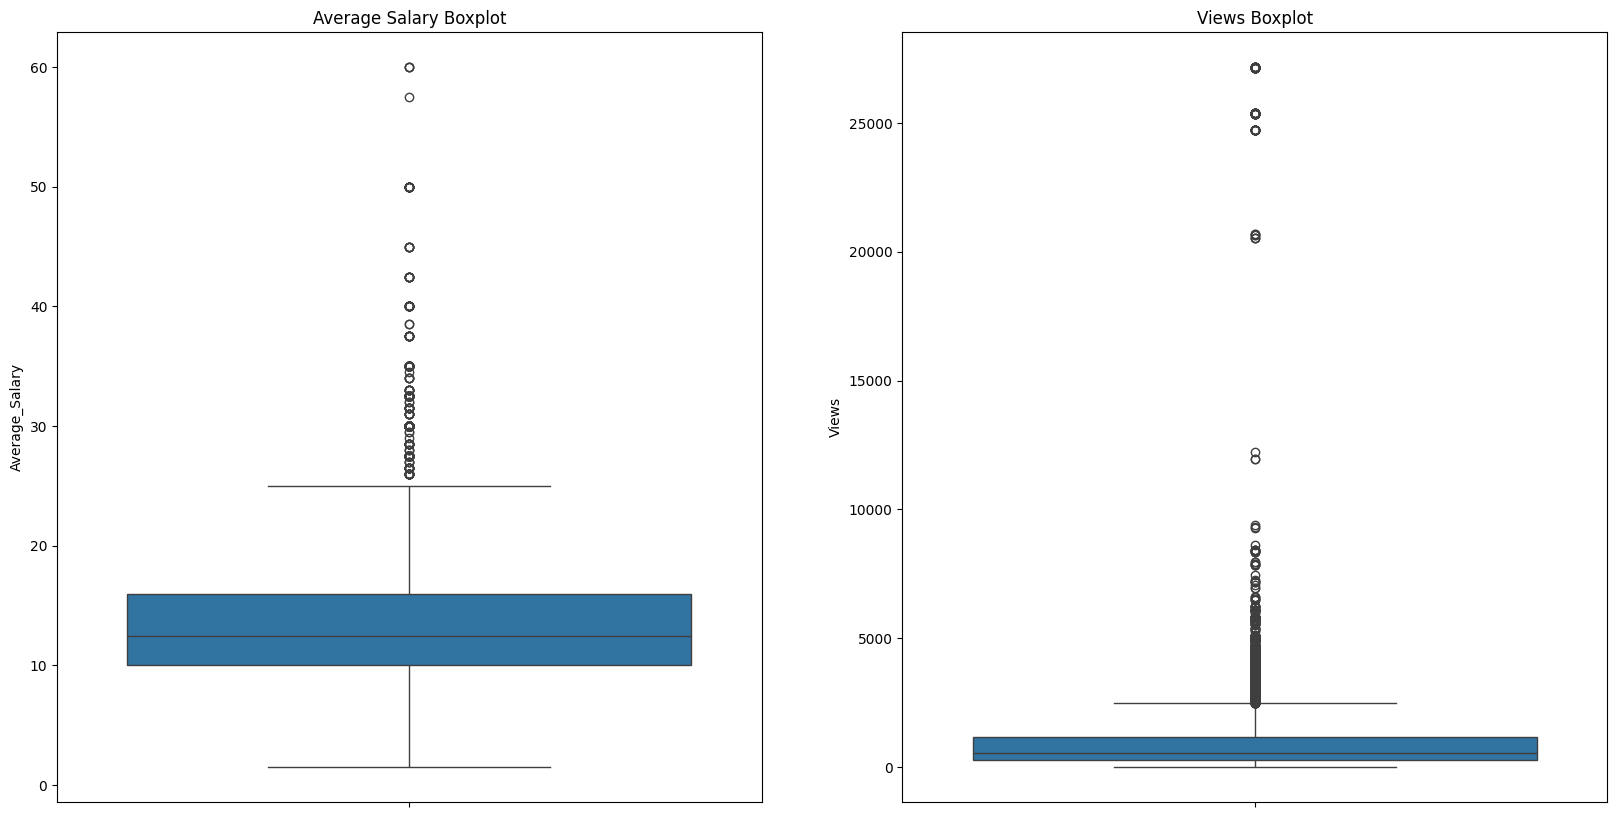

In [ ]:
# Biểu đồ boxplot của lương trung bình và lượt xem
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Average_Salary'])
plt.title('Average Salary Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Views'])
plt.title('Views Boxplot')
plt.show()

In [ ]:
outliers = df[(df['Views'] > 10000) | (df['Average_Salary'] > 50)]
print(f'Số lượng outliers: {len(outliers)}')

# Xóa outliers
df = df[(df['Views'] <= 10000) & (df['Average_Salary'] <= 50)]
df.reset_index(drop=True, inplace=True)
df.info()

Số lượng outliers: 84
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16635 entries, 0 to 16634
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Views                   16635 non-null  float64
 1   Recruitment_Area        16635 non-null  object 
 2   Gender_Requirement      16635 non-null  object 
 3   Level                   16635 non-null  object 
 4   Working_Form            16635 non-null  object 
 5   Degree_Requirement      16635 non-null  object 
 6   Experience_Requirement  16635 non-null  object 
 7   Company_Type            16635 non-null  object 
 8   Average_Salary          16635 non-null  float64
 9   Age_Group               16635 non-null  object 
 10  Main_Job                16635 non-null  object 
 11  Related_Job1            16635 non-null  object 
 12  Related_Job2            16635 non-null  object 
dtypes: float64(2), object(11)
memory usage: 1.7+ MB


- Chúng ta có thể những cột đặt trưng tất cả là dữ liệu phân loại. Chúng ta sẽ xem xét tiếp ảnh hưởng của những cột này qua phân tích thống kê.

In [ ]:
features = df.select_dtypes(include=['object']).columns
print(features)
target_1 = 'Average_Salary'
target_2 = 'Views'

Index(['Recruitment_Area', 'Gender_Requirement', 'Level', 'Working_Form',
       'Degree_Requirement', 'Experience_Requirement', 'Company_Type',
       'Age_Group', 'Main_Job', 'Related_Job1', 'Related_Job2'],
      dtype='object')


## 1.1 Xem xét dữ liệu phân loại (categorical data)

- Thực hinej phân tích  ANOVA (Analysis of Variance) một chiều (One-Way ANOVA), nhằm kiểm tra xem từng biến độc độc lập trong tập dữ liệu có ảnh hưởng đến biến mục tiêu (target variable) hay không

In [ ]:
affect_categorical_columns = []
for column in features:
    model = ols(f'{target_1} ~ {column}', data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(f'\nANOVA for {column}:\n', aov_table)

    # Kiểm tra giả thuyết
    if aov_table['PR(>F)'].iloc[0] < 0.05:
        print(f'\n{column} có ảnh hưởng đến mức lương trung bình')
        affect_categorical_columns.append(column)
    else:
        print(f'\n{column} không có ảnh hưởng đến mức lương trung bình')
print(f'\nSố cột ảnh hưởng đến mức lương trung bình: {len(affect_categorical_columns)}')
features = affect_categorical_columns


ANOVA for Recruitment_Area:
                          sum_sq       df        F         PR(>F)
Recruitment_Area   29128.769226    124.0  7.85389  2.488064e-127
Residual          493813.216287  16510.0      NaN            NaN

Recruitment_Area có ảnh hưởng đến mức lương trung bình

ANOVA for Gender_Requirement:
                            sum_sq       df          F        PR(>F)
Gender_Requirement    4344.640721      2.0  69.668757  7.400833e-31
Residual            518597.344792  16632.0        NaN           NaN

Gender_Requirement có ảnh hưởng đến mức lương trung bình

ANOVA for Level:
                  sum_sq       df           F  PR(>F)
Level      75899.223214      5.0  564.656578     0.0
Residual  447042.762298  16629.0         NaN     NaN

Level có ảnh hưởng đến mức lương trung bình

ANOVA for Working_Form:
                      sum_sq       df          F         PR(>F)
Working_Form   41371.256531      5.0  285.71613  3.162441e-294
Residual      481570.728981  16629.0        NaN   

- Như vậy tất cả các cột đều ảnh hưởng đến mức lương trung bình. Chúng ta sẽ mã hóa các cột này để có thể sử dụng cho mô hình học máy.

# 2.  Chuẩn bị dữ liệu
- Chúng ta áp dụng mã hóa dữ liệu phân loại bằng phương pháp mã hóa label encoding
- Chúng ta sẽ chia dữ liệu thành tập huấn luyện và tập kiểm tra

## 2.2 Mã hóa dữ liệu phân loại

In [ ]:
df_encoding = df[features].copy()
label_encoders = {}
for col in features:

    # Áp dụng Label Encoding
    le = LabelEncoder()
    df_encoding[col] = le.fit_transform(df_encoding[col])
    # Lưu trữ lại label encoder
    label_encoders[col] = le
df_encoding

,Recruitment_Area,Gender_Requirement,Level,Working_Form,Degree_Requirement,Experience_Requirement,Company_Type,Age_Group,Main_Job,Related_Job1,Related_Job2
0,64,0,1,4,0,6,1,0,16,33,28
1,107,2,1,4,0,1,1,0,39,16,14
2,107,2,1,4,2,0,1,2,25,25,16
3,107,0,1,4,2,0,1,0,25,16,23
4,107,0,5,4,5,6,1,0,3,33,16
...,...,...,...,...,...,...,...,...,...,...,...
16630,78,2,1,3,0,5,1,2,22,43,3
16631,107,0,1,3,0,5,0,0,15,43,16
16632,107,0,2,3,2,5,0,4,3,7,43
16633,107,0,2,3,0,5,0,0,28,43,23


# 3. Mô hình hóa dữ liệu

- Sử dụng Cross-Validation (CV) dùng để đánh giá hiệu suất của mô hình. Mục đích của nó là kiểm tra độ chính xác và khả năng tổng quát hóa của mô hình khi áp dụng dữ liệu test. Nguyên tắc hoạt động K-fold Cross-Validation là
  - chia dữ liệu thành K phần (folds) bằng nhau.
  - Quá trình huấn luyện và kiểm tra được lặp lại K lần. Mỗi lần, một fold được giữ lại làm tập kiểm tra, và K-1 folds còn lại được sử dụng để huấn luyện mô hình.
  - Kết quả cuối cùng là trung bình của các kết quả kiểm tra từ K lần lặp lại.

- Lợi ích:
  - Giúp đánh giá mô hình một cách đáng tin cậy bằng cách giảm thiểu hiện tượng overfitting (quá khớp) và underfitting (khớp kém).
  - Đảm bảo rằng mô hình được kiểm tra trên nhiều phần khác nhau của dữ liệu, cung cấp một cái nhìn toàn diện về hiệu suất của mô hình.


- GridSearchCV là một kỹ thuật tìm kiếm tham số tối ưu cho mô hình học máy bằng cách thử nghiệm một cách hệ thống tất cả các kết hợp có thể của các tham số được xác định trước (grid of parameters).

- Nguyên tắc:
  - GridSearchCV sẽ huấn luyện và đánh giá mô hình với từng tổ hợp của các tham số trong grid.
  - Sử dụng Cross-Validation (thường là K-fold) để đánh giá mỗi tổ hợp tham số. Điều này đảm bảo rằng kết quả là đáng tin cậy và không phụ thuộc vào một phần dữ liệu cụ thể.
  - GridSearchCV sẽ chọn bộ tham số có hiệu suất tốt nhất dựa trên tiêu chí đánh giá (scoring metric), ví dụ: Mean Squared Error (MSE) cho bài toán hồi quy.


In [ ]:
def train_and_evaluate_models(X, y):
    models = {
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'XGBoost': XGBRegressor(),
        'Extra Trees': ExtraTreesRegressor(),
        'Decision Tree': DecisionTreeRegressor(),
        'KNN': KNeighborsRegressor(),

    }

    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 500],
            'max_features': [1.0, 'sqrt', 'log2'],
            'max_depth': [4, 5, 6, 7, 8]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5]
        },
        'Extra Trees': {
            'n_estimators': [100, 200, 500],
            'max_features': [1.0, 'sqrt', 'log2']
        },
        'Decision Tree': {
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 3, 4]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }

    # K-fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    best_models = {}

    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_names = []
    best_params = []
    mses = []
    maes = []
    r2s = []

    # Kích thước của ô vẽ
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
    axs = axs.flatten()

    # Grid Search và huấn luyện mô hình
    for i, (model_name, model) in enumerate(models.items()):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring='neg_mean_squared_error', cv=kf)
        grid_search.fit(X_train, y_train)

        best_models[model_name] = grid_search.best_estimator_

        predictions = best_models[model_name].predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_names.append(model_name)
        best_params.append(grid_search.best_params_)
        mses.append(mse)
        maes.append(mae)
        r2s.append(r2)

        # In thông tin đánh giá mô hình
        print(f"{model_name}:")
        print(f"  Best Parameters: {grid_search.best_params_}")
        print(f"  MSE: {mse}")
        print(f"  RMSE: {rmse}")
        print(f"  MAE: {mae}")
        print(f"  R2: {r2}\n")

        # Vẽ biểu đồ
        sns.scatterplot(x=y_test, y=predictions, ax=axs[i])
        axs[i].set_title(f'{model_name}', fontsize=12)
        axs[i].set_xlabel('Actual Salary')
        axs[i].set_ylabel('Predicted Salary')

    # Tinh chỉnh layout
    plt.tight_layout()
    plt.show()

    evaluation = pd.DataFrame({
        'Model': model_names,
        'Best Parameters': best_params,
        'MSE': mses,
        'MAE': maes,
        'R2': r2s
    })

    return best_models, evaluation

## 3.1 Huấn luyện mô hình dự đoán lương

Random Forest:
  Best Parameters: {'max_depth': 8, 'max_features': 1.0, 'n_estimators': 500}
  MSE: 15.256664616226718
  RMSE: 3.9059780614113437
  MAE: 2.7186411584978147
  R2: 0.5139130382811512

Gradient Boosting:
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  MSE: 9.82516718140567
  RMSE: 3.1345122716948595
  MAE: 2.082631242463171
  R2: 0.6869639738616473

XGBoost:
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  MSE: 9.900395617468067
  RMSE: 3.1464894116249726
  MAE: 2.087818474473271
  R2: 0.68456714841911

Extra Trees:
  Best Parameters: {'max_features': 'log2', 'n_estimators': 500}
  MSE: 6.563752206097432
  RMSE: 2.561982085436475
  MAE: 1.0348739571419463
  R2: 0.7908747129471618

Decision Tree:
  Best Parameters: {'max_depth': 5, 'min_samples_split': 2}
  MSE: 21.67716030112998
  RMSE: 4.655873741966161
  MAE: 3.309255192124641
  R2: 0.30935199438927385

KNN:
  Best Parameters: {'n_neighbors': 7, 'p': 1, 'we

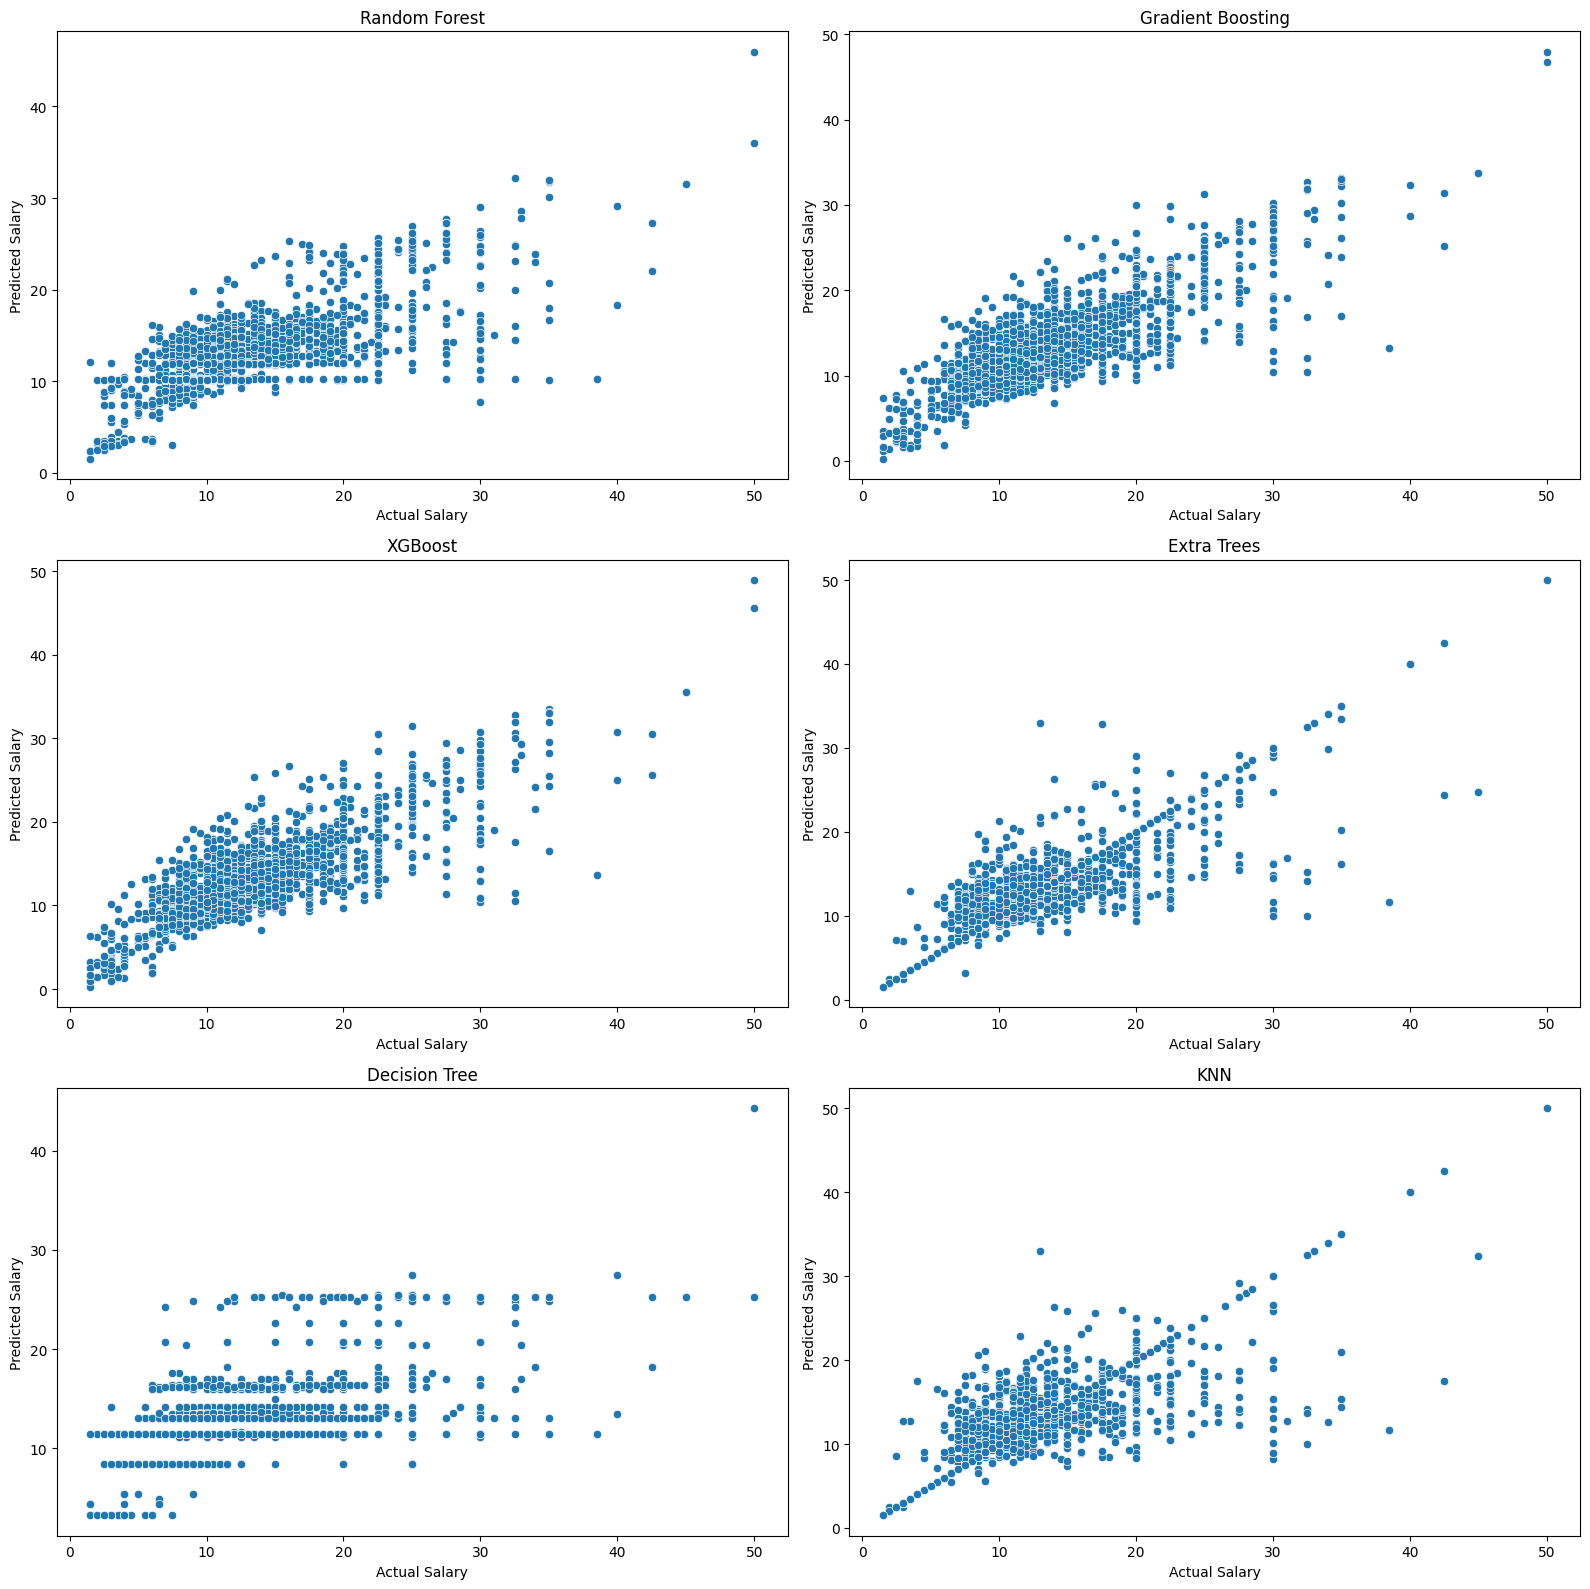

Mô hình tốt nhất cho mức lương trung bình: Extra Trees


In [ ]:
X = df_encoding
y = df[target_1]
best_models_salary, evaluation_salary = train_and_evaluate_models(X, y)
# Chọn ra mô hình tốt nhất dự vào R2

best_model_salary = evaluation_salary.loc[evaluation_salary['R2'].idxmax()]
print(f'Mô hình tốt nhất cho mức lương trung bình: {best_model_salary["Model"]}')

In [ ]:
evaluation_salary

,Model,Best Parameters,MSE,MAE,R2
0,Random Forest,"{'max_depth': 8, 'max_features': 1.0, 'n_estim...",15.256665,2.718641,0.513913
1,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9.825167,2.082631,0.686964
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9.900396,2.087818,0.684567
3,Extra Trees,"{'max_features': 'log2', 'n_estimators': 500}",6.563752,1.034874,0.790875
4,Decision Tree,"{'max_depth': 5, 'min_samples_split': 2}",21.677160,3.309255,0.309352
5,KNN,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",9.117886,1.266560,0.709498


## 3.2 Huấn luyện mô hình dự đoán số lượng người quan tâm

Random Forest:
  Best Parameters: {'max_depth': 8, 'max_features': 1.0, 'n_estimators': 500}
  MSE: 654351.880060267
  RMSE: 808.9201938759269
  MAE: 549.0234641212026
  R2: 0.3579230244587931

Gradient Boosting:
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  MSE: 500240.41924284096
  RMSE: 707.2767628325145
  MAE: 461.8223814177683
  R2: 0.5091435277891672

XGBoost:
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  MSE: 511808.0531240371
  RMSE: 715.4076132695521
  MAE: 471.2371688283239
  R2: 0.4977928896952989

Extra Trees:
  Best Parameters: {'max_features': 'log2', 'n_estimators': 500}
  MSE: 301621.18947458756
  RMSE: 549.2005002497608
  MAE: 252.96062702282353
  R2: 0.7040368844372424

Decision Tree:
  Best Parameters: {'max_depth': 5, 'min_samples_split': 3}
  MSE: 851459.8813068308
  RMSE: 922.7458378702289
  MAE: 627.6641582603953
  R2: 0.16451254738686993

KNN:
  Best Parameters: {'n_neighbors': 7, 'p': 1, 'wei

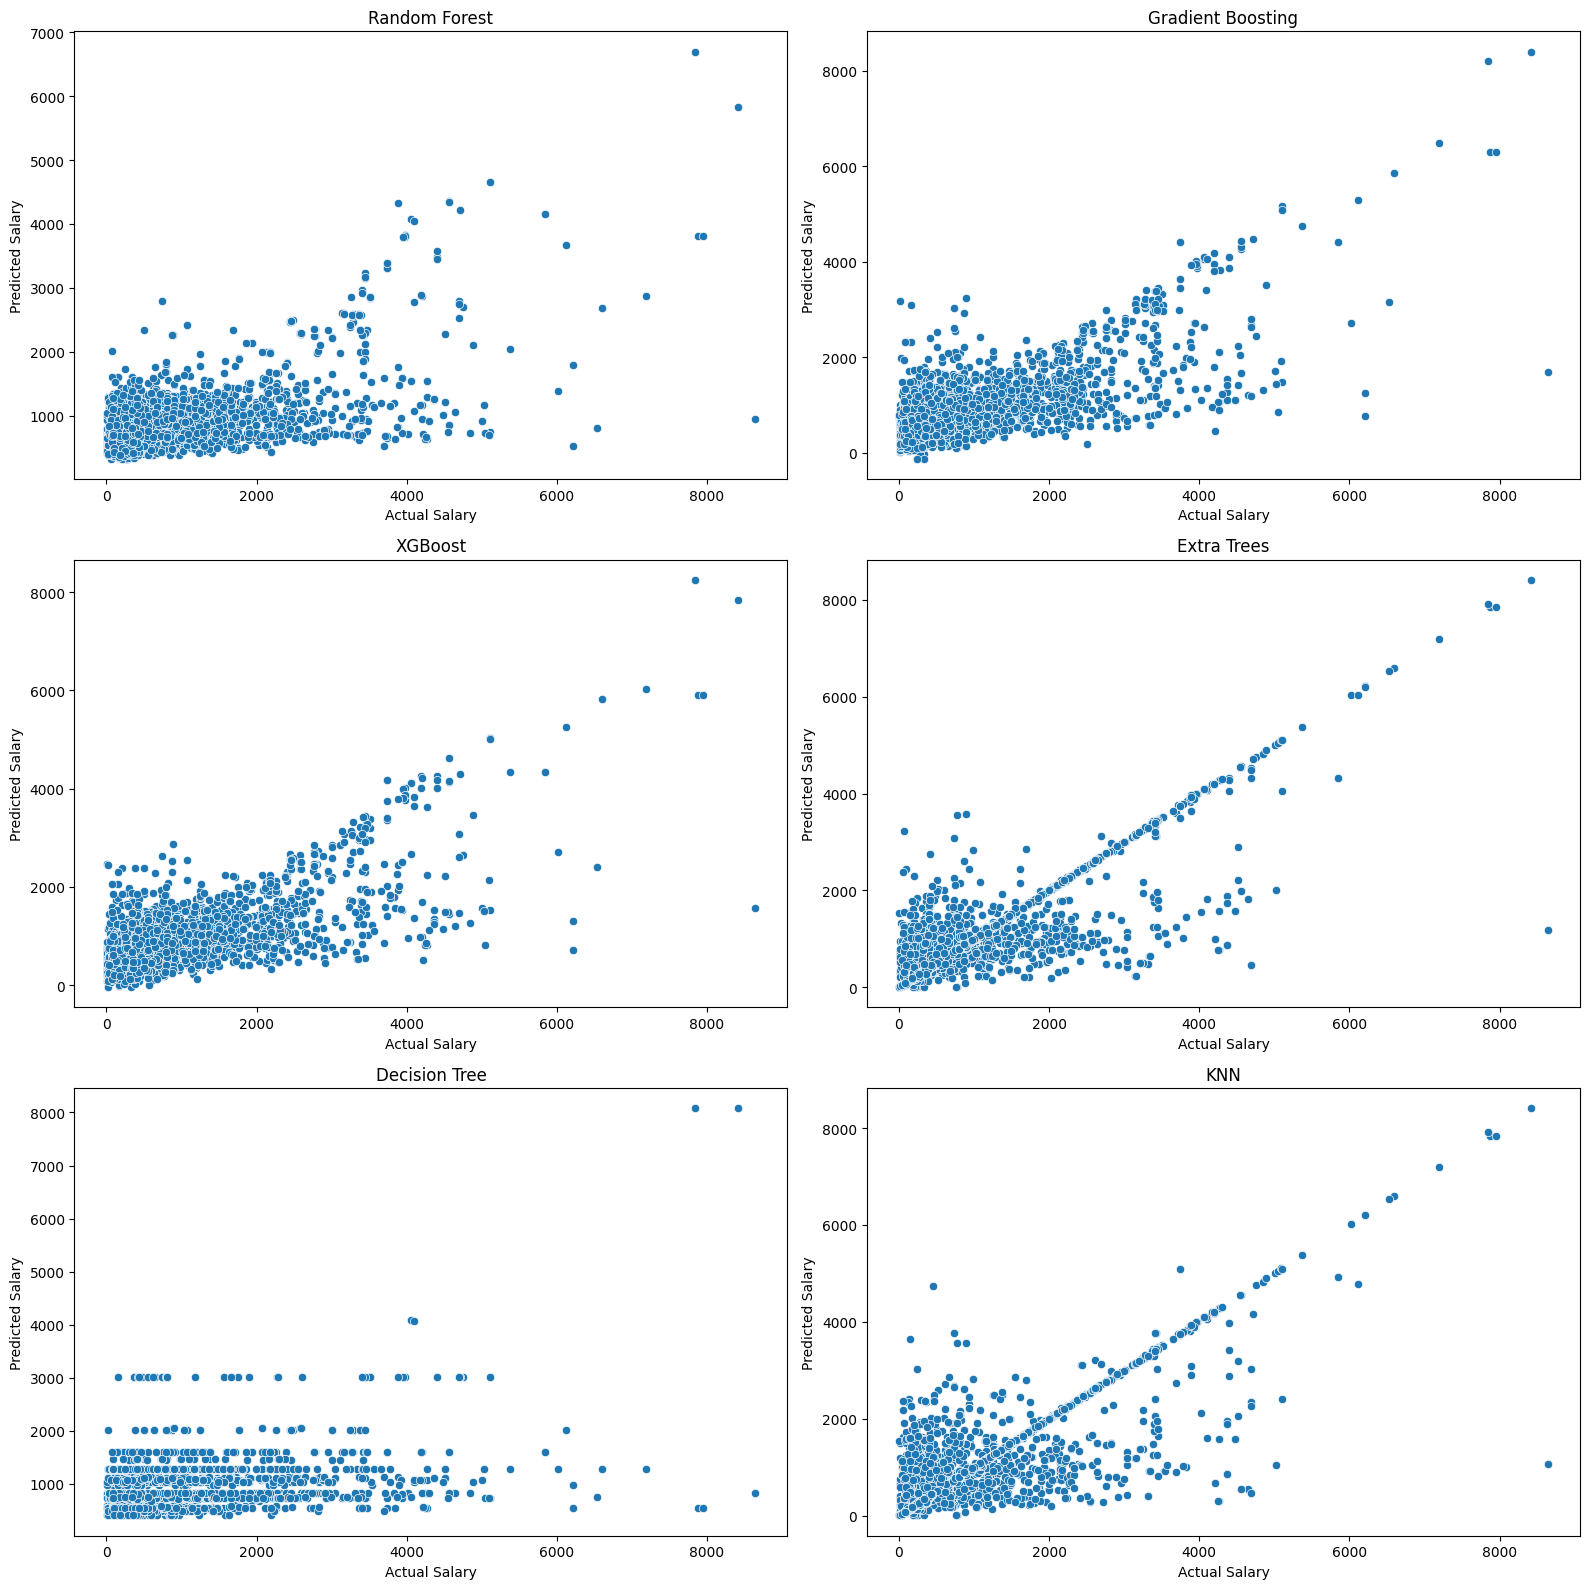

Mô hình tốt nhất cho dự đoán người quan tâm: Extra Trees


In [ ]:
X = df_encoding
y = df[target_2]
best_models_views, evaluation_views = train_and_evaluate_models(X, y)

best_model_views = evaluation_views.loc[evaluation_views['R2'].idxmax()]
print(f'Mô hình tốt nhất cho dự đoán người quan tâm: {best_model_views["Model"]}')

In [ ]:
evaluation_views

,Model,Best Parameters,MSE,MAE,R2
0,Random Forest,"{'max_depth': 8, 'max_features': 1.0, 'n_estim...",654351.880060,549.023464,0.357923
1,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",500240.419243,461.822381,0.509144
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",511808.053124,471.237169,0.497793
3,Extra Trees,"{'max_features': 'log2', 'n_estimators': 500}",301621.189475,252.960627,0.704037
4,Decision Tree,"{'max_depth': 5, 'min_samples_split': 3}",851459.881307,627.664158,0.164513
5,KNN,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",380730.908216,287.592460,0.626411


## 3.3 Kết luận

- Dự vào các tham số MSE, MAE đặc biệt là R2 có thể cho thấy mô hình Extra Trees cho hiệu quả rất cao cho cả mô hình dự đoán mức lương trung bình cũng như là dự đoán số người quan tâm với (MSE và MAE thấp nhất, R2 cao nhất).Điều này chỉ ra rằng Extra Trees không chỉ dự đoán gần với giá trị thực tế hơn mà còn giải thích được phần lớn biến thiên trong dữ liệu. KNN cũng cho dự đoán khá tốt với tốc độ nhanh và chính xác.
- Thứ tự mô hình theo R2:  Extra Trees > KNN >  Gradient Boosting > XGBoost > Random Forest > Decision Tree

In [ ]:
# Lưu các mô hình tốt nhất lại để sử dụng cùng với các label encoder
import pickle

for model_name, model in best_models_salary.items():
    with open(f'{path.save_model}Salary_Model/{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
for model_name, model in best_models_views.items():
    with open(f'{path.save_model}Views_Model/{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)

for column, le in label_encoders.items():
    with open(f'{path.save_model}Label_Encoders/{column}.pkl', 'wb') as f:
        pickle.dump(le, f)
print('Lưu mô hình thành công!')


Lưu mô hình thành công!
